In [41]:
import warnings
warnings.filterwarnings('ignore')

import os
import nltk
import numpy as np
import pandas as pd

## Read in dataset
Load the [Reuter 50_50 training dataset](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50).

TODO:  download and extract directly from website

In [2]:
# source modified from:
# https://github.com/devanshdalal/Author-Identification-task/blob/master/learner.py
path = 'data/C50/C50train/'
authors = os.listdir(path)
data = []

for author in authors:
  texts = os.listdir(path + author + '/')
  for text in texts:
    f=open(path + author + '/' + text, 'r')
    data.append([author, f.read()])
    f.close()
    
df = pd.DataFrame(data, columns=["author", "text"])
df.head()

# TODO: add more author, text pairs

,author,text
0,RobinSidel,Drugstore giant Revco D.S. Inc. said Monday it...
1,RobinSidel,"Mattel Inc., seeking to expand in the market f..."
2,RobinSidel,A financial agreement between Barney's Inc and...
3,RobinSidel,An independent shareholder advisory firm recom...
4,RobinSidel,Raising the stakes in the escalating battle fo...


## Preprocess data
### Process text

Using TensorFlow backend.


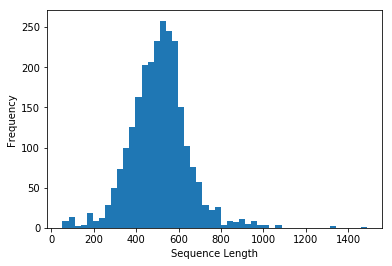

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

tokenizer = Tokenizer(nb_words=20000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')

tokenizer.fit_on_texts(df["text"])
X = tokenizer.texts_to_sequences(df["text"])

# plot histogram 
num_words = [len(n) for n in X]
plt.hist(num_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Pad sequences, use 500 as maximum length.
X = pad_sequences(X, maxlen=500)

print("Here is the first text tokenized, size {}:\n".format(len(X[0])), X[0])

Here is the first text tokenized, size 500:
 [  203    64     9  1864    10     1    41    27    14   694     8    47
    57 10446  1881   235   203    64   224 10446    80  1297    40   307
    89   272    15  1133   216     4    64     9     1    36   393    80
   250   201  8975    84    42    15   505    40  1487   565   272     5
  1364   180     9  1316    13 10446   112   860  4841  2325     6   462
     6    87  6499    37   115   868  1032   120   933   288   954   764
     6   256   120    87   470   391    72  5156    34  1743    22   579
     1   933    41     2  2096   264    59     4  1432   764     3   861
 17281     7   201   682     7    12    22   311    13  4011     2  1506
     4  3542  1199   234   171    72   528  7482  3754   201   682    24
    46  2640   523    10    25  5157     1  6500  4592     3  1708   719
  2139    70     6   582  2266  1578    12    24    46  1691    16 12794
   123   801     6    87     6    17   156    25  1940   645   558    71
  1099

### Process authors

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoded = encoder.fit_transform(df["author"])
y = to_categorical(encoded)

print("Author {} is one-hot encoded as:\n".format(df["author"][0]), y[0])

Author RobinSidel is one-hot encoded as:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## Training
### Create training and test sets

In [51]:
from sklearn.model_selection import train_test_split

# Keeps some authors aside for hash testing
x_train, x_new, y_train, y_new = train_test_split(X, y, train_size=0.8, shuffle=False)

# Split remainder into 70% training and 30% testing and shuffle
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.7, random_state=1)

print("New:  {} text from {} authors".format(x_new.shape[0], len(np.unique(y_new, axis=0))))
print("Train: {} text from {} authors".format(x_train.shape[0], len(np.unique(y_train, axis=0))))
print("Test:  {} text from {} authors".format(x_test.shape[0], len(np.unique(y_test, axis=0))))

New:  500 text from 10 authors
Train: 1400 text from 40 authors
Test:  600 text from 40 authors


In [105]:
print("Sample training data, showing authors")
print(np.argmax(y_train, axis=1)[:100])

Sample training data, showing authors
[ 6 39 40 45  3 46 23  3  5  8  1 10 20 41 25 49 21 15 14  7 10 13 28 22
  0 39 20 14 25 22 40  7 35  5 33  8 33 29 35 38  1 28 16 40 15 10 27  9
 23 13  5 46 41 27 10 33  5 40 45  9 10 18 20 45 21 29 45 36 31 41 21  0
 14 18 40 27 12 33 19 41 20  8 23 13  8 27 34 14 16 27 22 16 19 28 16 15
 10 17 16 36]


### Create network model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, SimpleRNN, RepeatVector
import keras

RUN_NAME = "run 4 with LSTM 128, embed 128, batch_size=10"
max_features = 20000

model = Sequential()
model.add(Embedding(max_features, 128, name='embed'))
model.add(LSTM(32, dropout=0.8, recurrent_dropout=0.2, name='lstm'))
model.add(Dense(50, activation='softmax', name='dense'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 50)                1650      
Total params: 2,582,258
Trainable params: 2,582,258
Non-trainable params: 0
_________________________________________________________________


### Train network

In [15]:
logger = keras.callbacks.TensorBoard(
    log_dir='logs/{}'.format(RUN_NAME),
    write_graph=True,
    histogram_freq=5
)

model.fit(x_train, 
          y_train,
          epochs=30,
          validation_split=0.2,
#          callbacks=[logger],
          shuffle=True)


Train on 1120 samples, validate on 280 samples
Epoch 1/30
1120/1120 [==============================] - 19s 17ms/step - loss: 3.9005 - acc: 0.0455 - val_loss: 3.8867 - val_acc: 0.1143
Epoch 2/30
1120/1120 [==============================] - 18s 16ms/step - loss: 3.8360 - acc: 0.0616 - val_loss: 3.8166 - val_acc: 0.0179
Epoch 3/30
1120/1120 [==============================] - 17s 15ms/step - loss: 3.7217 - acc: 0.0455 - val_loss: 3.7102 - val_acc: 0.0750
Epoch 4/30
1120/1120 [==============================] - 17s 16ms/step - loss: 3.6289 - acc: 0.0982 - val_loss: 3.6156 - val_acc: 0.1071
Epoch 5/30
1120/1120 [==============================] - 17s 15ms/step - loss: 3.5035 - acc: 0.1545 - val_loss: 3.4953 - val_acc: 0.1750
Epoch 6/30
1120/1120 [==============================] - 17s 15ms/step - loss: 3.3575 - acc: 0.1839 - val_loss: 3.3904 - val_acc: 0.1714
Epoch 7/30
1120/1120 [==============================] - 18s 16ms/step - loss: 3.2056 - acc: 0.2241 - val_loss: 3.2824 - val_acc: 0.1857
E

### Test network

In [16]:
score, acc = model.evaluate(x_test, y_test, batch_size=200)

print('Test score:', score)
print('Test accuracy:', acc)

600/600 [==============================] - 0s 796us/step
Test score: 2.616125742594401
Test accuracy: 0.39666666587193805


### Create and compare hashes

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

def get_author(index):
    one_hot = y_new[index]
    i = np.argmax(one_hot)
    return encoder.inverse_transform(i)

def get_hash(text):
    prediction = model.predict(text)
    prediction = prediction[-1]
    return prediction

def get_similarity(hash1, hash2):
    return float(cosine_similarity([hash1], [hash2]))

x_hash = [get_hash(x) for x in x_new]

In [96]:
def get_similarity_from_index(i, j):
    return get_similarity(x_hash[i], x_hash[j])

def print_similarity(i, j):
    similarity = get_similarity_from_index(i, j)
    
    if get_author(i) == get_author(j):
        print("Comparision of text {} and {} \tfor same author {} is: \t\t{}".format(
             i, j, get_author(i), similarity))
    else:
        print("Comparision of text {} and {} \tfor authors {} and {} is: \t{}".format(
             i, j, get_author(i), get_author(j), similarity))
    
print_similarity(0,2)
print_similarity(0,11)
print_similarity(0,60)
print_similarity(0,110)

Comparision of text 0 and 2 	for same author MatthewBunce is: 		1.0
Comparision of text 0 and 11 	for same author MatthewBunce is: 		1.0
Comparision of text 0 and 60 	for authors MatthewBunce and ToddNissen is: 	0.834044337272644
Comparision of text 0 and 110 	for authors MatthewBunce and PeterHumphrey is: 	0.759009063243866


In [136]:
true_positive, true_negative, false_positive, false_negative = 0,0,0,0
margin = 0.8
num_texts = len(x_new)

for i in range(num_texts):
    for j in range(min(i+1, num_texts), num_texts):
        similarity = get_similarity_from_index(i, j)
        
        if similarity >= margin:
            if get_author(i) == get_author(j):
                true_positive += 1
            else:
                false_positive += 1
        else:
            if get_author(i) == get_author(j):
                false_negative += 1
            else:
                true_negative += 1

print("True positives ", true_positive)
print("False positives", false_positive)
print("True negatives ", true_negative)
print("False negatives", false_negative)

True positives  8273
False positives 58658
True negatives  53842
False negatives 3977


In [140]:
# Comparison just for the same author
y_new_ints = np.unique(np.argmax(y_new, axis=1))
y_new_authors = encoder.inverse_transform(y_new_ints)
new_authors = {name:{"correct":0, "incorrect":0} for name in y_new_authors}

for i in range(num_texts):
    author_i = get_author(i)
    
    for j in range(min(i+1, num_texts), num_texts):
        if author_i == get_author(j):
            similarity = get_similarity_from_index(i, j)
            if similarity >= margin:
                new_authors[author_i]["correct"] += 1
            else:
                new_authors[author_i]["incorrect"] += 1

print("Number of correctly identified text belonging to each author:")             
new_authors

Number of correctly identified text belonging to each author:


{'AlexanderSmith': {'correct': 524, 'incorrect': 701},
 'BernardHickey': {'correct': 636, 'incorrect': 589},
 'GrahamEarnshaw': {'correct': 952, 'incorrect': 273},
 'KirstinRidley': {'correct': 567, 'incorrect': 658},
 'LydiaZajc': {'correct': 1086, 'incorrect': 139},
 'MatthewBunce': {'correct': 976, 'incorrect': 249},
 'PeterHumphrey': {'correct': 982, 'incorrect': 243},
 'SarahDavison': {'correct': 745, 'incorrect': 480},
 'TimFarrand': {'correct': 649, 'incorrect': 576},
 'ToddNissen': {'correct': 1156, 'incorrect': 69}}

In [146]:
[new_authors[d]["correct"] for d in new_authors]

[524, 636, 952, 567, 1086, 976, 982, 745, 649, 1156]

In [158]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=y_new_authors,
    y=[new_authors[d]["correct"] for d in new_authors],
    name='Correct'
)
trace2 = go.Bar(
    x=y_new_authors,
    y=[new_authors[d]["incorrect"] for d in new_authors],
    name='Incorrect'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Hash correctness using Margin=0.8',
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='jupyter-basic_bar')

### Analysis

The chart above shows that the neural network does a great job of identifying the text written by Lydia and Todd and a good job identifying the text from Graham, Matthew, and Peter.  For the other authors, it does not perform as well; in two cases (Alexander and Kristin) it is wrong more than it is right.  Another issue is the large percentage of false positives when compared other author texts.  While some text from different authors may share certain characteristics, the goal of the algorithm is to maximize their differences.

More work will coming in two areas:  (1) improving the network to have > 80% test accuracy (if possible) and improving the comparision algorithm's ability to differentiate texts.